# (28) debug — why different from pvae?

**Motivation**: host = ```mach```, device = ```cuda:3``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick

device_idx = 3
device = f'cuda:{device_idx}'

## Init Iterative PVAE

### Get configs

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')

cfg_vae['init_scale'] = 1e-2

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 3000
cfg_tr['batch_size'] = 1000
cfg_tr['kl_beta'] = 1.0

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_ch': 32, 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 
'dec_type': 'lin', 'enc_bias': False, 'dec_bias': False, 'init_dist': 'Normal', 'init_scale': 0.01}

Trainer:
{'lr': 0.002, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0, 'kl_beta': 1.0}

### Make model + trainer

In [4]:
tr_pvae = TrainerVAE(
    MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae)),
    ConfigTrainVAE(**cfg_tr),
    device=device,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_z-512_fp_nrm-none_<lin|lin>
mc_b1000-ep3000-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_28,12:19)

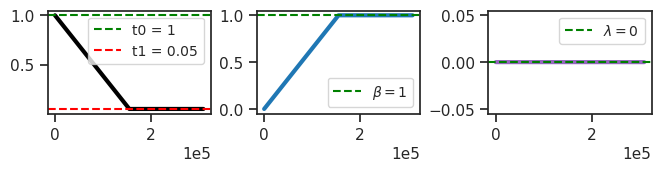

In [5]:
tr_pvae.model.print()
print(f"{tr_pvae.model.cfg.name()}\n{tr_pvae.cfg.name()}_({tr_pvae.model.timestamp})\n")
tr_pvae.show_schedules()

In [6]:
print(vars(tr_pvae.model.cfg))

{
    'prior_log_dist': 'uniform',
    'prior_clamp': -4,
    'hard_fwd': False,
    'exc_only': False,
    'rmax_q': 1.0,
    'type': 'poisson',
    'enc_type': 'lin',
    'dec_type': 'lin',
    'enc_bias': False,
    'dec_bias': False,
    'enc_norm': False,
    'dec_norm': False,
    'dataset': 'vH16',
    'input_sz': 16,
    'n_ch': 32,
    'n_latents': 512,
    'fit_prior': True,
    'use_bn': False,
    'use_se': True,
    'res_eps': 1.0,
    'init_dist': 'Normal',
    'init_scale': 0.01,
    'activation_fn': 'swish',
    'seed': 0,
    'base_dir': '/home/hadi/Projects/PoissonVAE',
    'data_dir': '/home/hadi/Datasets',
    'runs_dir': '/home/hadi/Projects/PoissonVAE/runs/poisson_uniform_c(-4)_vH16_z-512_fp_nrm-none_<lin|lin>',
    'mods_dir': '/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-4)_vH16_z-512_fp_nrm-none_<lin|lin>',
    'results_dir': '/home/hadi/Projects/PoissonVAE/results'
}

In [7]:
print(vars(tr_pvae.cfg))

{
    'lr': 0.002,
    'epochs': 3000,
    'batch_size': 1000,
    'warm_restart': 0,
    'warmup_epochs': 5,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'weight_decay': 0.0, 'betas': (0.9, 0.999), 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 2995.0, 'eta_min': 1e-05},
    'ema_rate': None,
    'grad_clip': 500,
    'chkpt_freq': 50,
    'eval_freq': 20,
    'log_freq': 10,
    'use_amp': False,
    'method': 'mc',
    'kl_beta': 1.0,
    'kl_beta_min': 0.0001,
    'kl_anneal_cycles': 0,
    'kl_anneal_portion': 0.5,
    'kl_const_portion': 0.0,
    'lambda_anneal': False,
    'lambda_init': 0.0,
    'lambda_norm': 0.0,
    'temp_anneal_portion': 0.5,
    'temp_anneal_type': 'lin',
    'temp_start': 1.0,
    'temp_stop': 0.05
}

In [8]:
self = tr_pvae
x = next(iter(self.dl_vld))[0]

recon_batch, kl, dist = self._fun(x)
kl.shape, recon_batch.shape

(torch.Size([1000, 512]), torch.Size([1000]))

In [9]:
kl_batch = torch.sum(kl, dim=1)
kl_batch.shape

torch.Size([1000])

In [10]:
recon_batch.mean(), kl_batch.mean()

(tensor(195.9986, device='cuda:1', grad_fn=<MeanBackward0>),
 tensor(0.0428, device='cuda:1', grad_fn=<MeanBackward0>))

In [11]:
loss = recon_batch + 1.0 * kl_batch
loss = torch.mean(loss)
loss

tensor(196.0414, device='cuda:1', grad_fn=<MeanBackward0>)

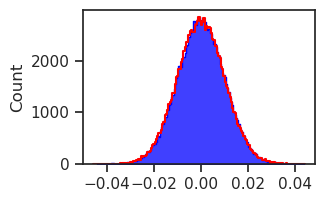

In [24]:
sns.histplot(tonp(self.model.fc_dec.weight.data).ravel(), element='step', color='b')
sns.histplot(tonp(self.model.fc_enc.weight.data).ravel(), element='step', fill=False, color='r');

In [26]:
self.model.temp, self.model.n_exp

(tensor(1., device='cuda:1'), tensor(263, device='cuda:1'))

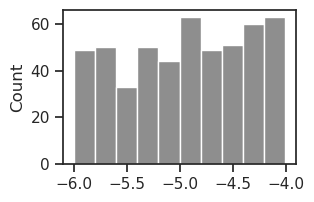

In [27]:
sns.histplot(tonp(self.model.log_rate.ravel()), color='dimgrey');

In [28]:
x = next(iter(self.dl_vld))[0]

with torch.inference_mode():
    output = self.model(x)
    dist, log_dr, spks, y = output

In [30]:
dist.rate

tensor([[0.0089, 0.0052, 0.0022,  ..., 0.0197, 0.0089, 0.0073],
        [0.0071, 0.0035, 0.0023,  ..., 0.0170, 0.0063, 0.0062],
        [0.0095, 0.0049, 0.0026,  ..., 0.0201, 0.0079, 0.0071],
        ...,
        [0.0091, 0.0036, 0.0028,  ..., 0.0140, 0.0087, 0.0072],
        [0.0077, 0.0045, 0.0022,  ..., 0.0123, 0.0079, 0.0066],
        [0.0084, 0.0051, 0.0023,  ..., 0.0141, 0.0087, 0.0049]],
       device='cuda:1')

In [ ]:
0.0127, 0.0105, 0.0030, 0.0140, 0.0027, 0.0147, 0.0030, 0.0149, 0.0088,

In [37]:
dist.rate[123]

tensor([0.0083, 0.0047, 0.0025, 0.0026, 0.0130, 0.0148, 0.0073, 0.0127, 0.0064,
        0.0129, 0.0106, 0.0030, 0.0141, 0.0028, 0.0139, 0.0031, 0.0146, 0.0083,
        0.0055, 0.0056, 0.0022, 0.0028, 0.0097, 0.0099, 0.0062, 0.0056, 0.0148,
        0.0150, 0.0093, 0.0077, 0.0098, 0.0054, 0.0035, 0.0088, 0.0067, 0.0053,
        0.0076, 0.0125, 0.0193, 0.0058, 0.0076, 0.0048, 0.0083, 0.0044, 0.0068,
        0.0135, 0.0040, 0.0078, 0.0035, 0.0109, 0.0092, 0.0049, 0.0122, 0.0026,
        0.0052, 0.0040, 0.0049, 0.0139, 0.0039, 0.0026, 0.0050, 0.0042, 0.0034,
        0.0068, 0.0052, 0.0105, 0.0042, 0.0160, 0.0056, 0.0028, 0.0080, 0.0143,
        0.0061, 0.0174, 0.0092, 0.0052, 0.0091, 0.0156, 0.0180, 0.0052, 0.0102,
        0.0077, 0.0064, 0.0105, 0.0065, 0.0104, 0.0106, 0.0142, 0.0031, 0.0104,
        0.0150, 0.0227, 0.0026, 0.0116, 0.0165, 0.0163, 0.0038, 0.0149, 0.0162,
        0.0120, 0.0062, 0.0042, 0.0149, 0.0132, 0.0045, 0.0069, 0.0071, 0.0117,
        0.0029, 0.0124, 0.0074, 0.0031, 

<Axes: ylabel='Count'>

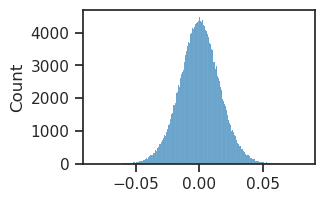

In [38]:
sns.histplot(tonp(y).ravel())

In [40]:
torch.linalg.norm(x - y)

tensor(442.7317, device='cuda:1')

In [41]:
torch.linalg.norm(x)

tensor(442.6510, device='cuda:1')

In [42]:
torch.linalg.vector_norm(x, dim=(1, 2, 3))

tensor([14.4046, 15.4132, 14.8398, 15.1299, 13.1299, 12.0474, 12.6726, 13.6746,
        14.6887, 14.0796, 13.9979, 15.2003, 13.6593, 13.4506, 15.0531, 12.3208,
        13.8885, 12.7999, 12.1138, 13.0240, 13.9159, 13.8612, 13.6127, 14.2003,
        11.6822, 13.7708, 14.2951, 15.2824, 14.3265, 13.7433, 13.8344, 15.5487,
        16.3575, 14.2952, 13.1245, 15.1856, 14.4638, 13.4401, 13.7101, 14.3593,
        11.5081, 14.0393, 14.6271, 15.8796, 16.8808, 16.3220, 14.2289, 14.9757,
        12.4999, 16.2572, 12.0800, 13.7548, 14.8087, 13.1106, 15.7339, 16.0155,
        13.8608, 14.6634, 15.3438, 13.4382, 15.3318, 15.5762, 13.3560, 14.3943,
        14.3849, 14.3042, 14.2314, 12.1575, 10.3384, 14.3008, 14.4180, 13.1513,
        15.1625, 13.1610, 14.3367,  8.6843, 13.0356, 14.6175, 13.2346, 14.2165,
        14.0713, 14.4185, 11.4811, 14.2833, 14.4565, 14.0744, 13.9111, 13.3582,
        15.1179, 10.4348, 13.7742, 11.9327, 13.2822, 13.7114, 11.1797, 14.5251,
        17.3526, 13.8741, 14.7631, 14.25

## Fit a model

In [3]:
model_type = 'poisson'
cfg_vae, cfg_tr = default_configs('vH16', model_type, 'lin|lin')

cfg_vae['init_scale'] = 1e-2

cfg_tr['lr'] = 2e-3
cfg_tr['epochs'] = 3000
cfg_tr['batch_size'] = 1000
cfg_tr['kl_beta'] = 1.0

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'vH16', 'n_ch': 32, 'n_latents': 512, 'prior_clamp': -4, 'fit_prior': True, 'enc_type': 'lin', 
'dec_type': 'lin', 'enc_bias': False, 'dec_bias': False, 'init_dist': 'Normal', 'init_scale': 0.01}

Trainer:
{'lr': 0.002, 'batch_size': 1000, 'epochs': 3000, 'optimizer_kws': {'weight_decay': 0.0}, 'grad_clip': 500, 
'kl_const_portion': 0.0, 'kl_beta': 1.0}

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-4)_vH16_z-512_fp_nrm-none_<lin|lin>
mc_b1000-ep3000-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_08_28,12:48)

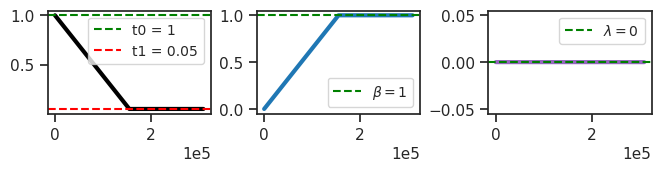

In [5]:
vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

In [6]:
comment = f"PVAE"
fit_name = f"{comment}_{tr.cfg.name()}"

tr.train(fit_name=fit_name)

epoch # 3000, avg loss: 165.515957: 100%|████████████████████████████████████████████████████| 3000/3000 [1:49:52<00:00,  2.20s/it]


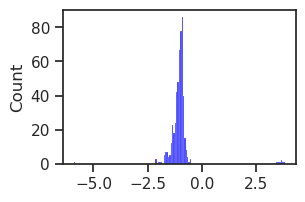

In [8]:
log_rate = tonp(tr.model.log_rate.ravel())
sns.histplot(log_rate, color='b');

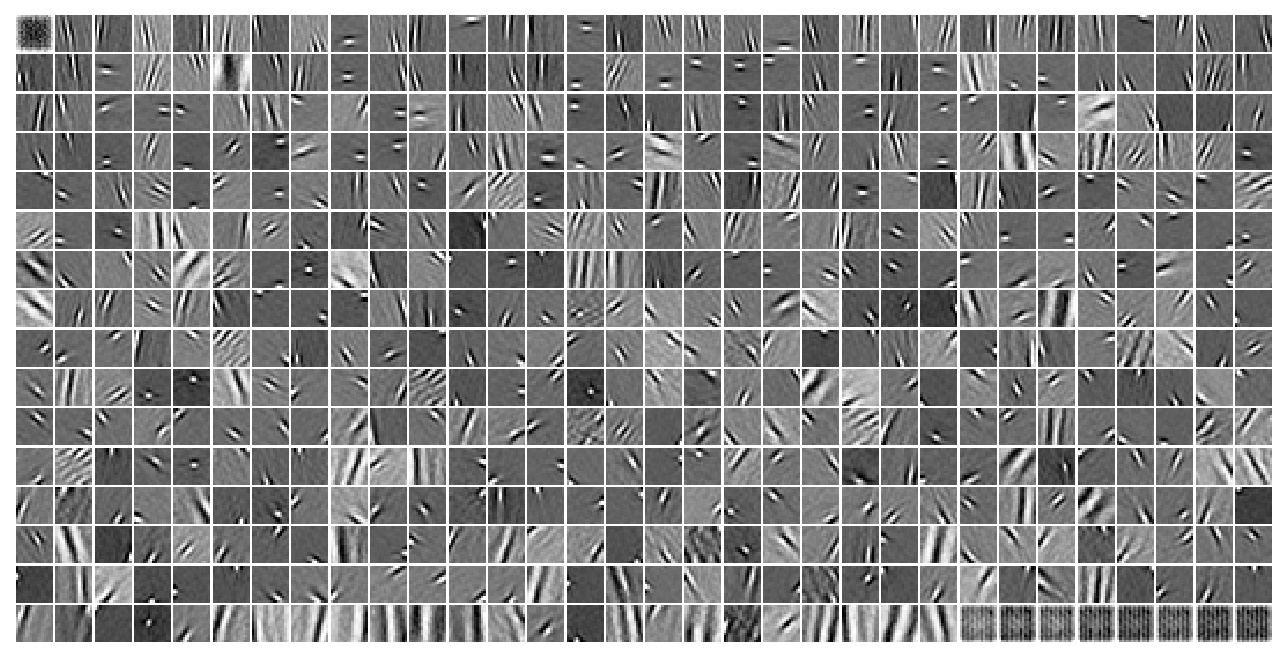

In [9]:
tr.model.show('dec', order=np.argsort(log_rate));

In [11]:
data, loss, etc = tr.validate(full_data=True)
kl_diag = loss['kl_diag'].copy()
loss = {
    k: np.mean(v, 0) for k, v in
    loss.items() if k != 'kl_diag'
}
loss['nelbo'] = loss['mse'] + loss['kl']
print(loss)

{'mse': 135.88268, 'kl': 32.052258, 'nelbo': 167.93494}